We begin by importing all the libraries we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import sklearn
import seaborn as sns
import scipy
from sqlalchemy import text
from scipy.stats import t

Step 1: Load the datasets.

In [2]:
cust_df = pd.read_csv('QVI_purchase_behaviour.csv')
trans_df = pd.read_excel('QVI_transaction_data.xlsx')



Copy the datasets to preserve originals

In [3]:
transactiondata = trans_df.copy()
customerdata = cust_df.copy()

Let's examine the datasets

In [4]:
transactiondata

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [5]:
customerdata

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


The date column is in INT datatype. Let's convert it to DATETIME.

In [6]:
transactiondata['DATE'] = pd.to_datetime(trans_df['DATE'], unit='D', origin='1899-12-30')
print(transactiondata['DATE'].dtype)

datetime64[ns]


1.1 Number of observations

In [7]:
print(f"Number of observations in Customer Data: {customerdata.shape}")
print(f"Number of observations in Transaction Data: {transactiondata.shape}")

Number of observations in Customer Data: (72637, 3)
Number of observations in Transaction Data: (264836, 8)


1.2 Number of duplications

In [8]:
print(f"Duplications in Customer Data: {customerdata.duplicated().sum()}")
print(f"Duplications in Transaction Data: {transactiondata.duplicated().sum()}")

Duplications in Customer Data: 0
Duplications in Transaction Data: 1


In [9]:
transaction_duplicates = transactiondata[transactiondata.duplicated()]
print("\nDuplicate rows in Transaction Data:")
print(transaction_duplicates)


Duplicate rows in Transaction Data:
             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
124845 2018-10-01        107          107024  108462        45   

                                     PROD_NAME  PROD_QTY  TOT_SALES  
124845  Smiths Thinly Cut   Roast Chicken 175g         2        6.0  


Let's drop the duplicate entry.

In [10]:
transactiondata = transactiondata.drop_duplicates()
print(f"Duplicates removed from Transaction Data. New shape: {transactiondata.shape}")

Duplicates removed from Transaction Data. New shape: (264835, 8)


1.3 Let's check for missing values

In [11]:
print("Missing Values in Customer Data:")
print(customerdata.isnull().sum())

print("\nMissing Values in Transaction Data:")
print(transactiondata.isnull().sum())

Missing Values in Customer Data:
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

Missing Values in Transaction Data:
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


Let's check if there are any missing dates.

In [12]:
# Generate a list of dates with transactions in ascending order 
date_counts = transactiondata.groupby('DATE').size()

# Then compare to a full list of dates within the same range to find differences between them 
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq='D')

The missing day is Christmas, this is expected.

1.4 Let's examine the data distribution and check for outliers.

In [13]:
transactiondata.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264835,264835.000000,2.648350e+05,2.648350e+05,264835.000000,264835.000000,264835.000000
mean,2018-12-30 00:52:42.252722944,135.080216,1.355496e+05,1.351584e+05,56.583201,1.907308,7.304205
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.000000,7.002100e+04,6.760100e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.000000,1.303580e+05,1.351380e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030945e+05,2.027015e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.784306,8.058011e+04,7.813316e+04,32.826692,0.643655,3.083231


In [14]:
customerdata.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


There appears to be an outlier in the transaction dataset (PROD_QTY = 200). Let's investigate this transaction further.

In [15]:
transactiondata.loc[transactiondata['PROD_QTY'] == 200.0]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [16]:
transactiondata.loc[transactiondata['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


This seems to be a special case so let us drop this from the dataset.

In [17]:
transactiondata = transactiondata[transactiondata['LYLTY_CARD_NBR'] != 226000]
transactiondata.shape

(264833, 8)

In [18]:
transactiondata.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264833,264833.000000,2.648330e+05,2.648330e+05,264833.000000,264833.000000,264833.000000
mean,2018-12-30 00:52:39.666657792,135.079529,1.355489e+05,1.351577e+05,56.583598,1.905812,7.299351
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-09-30 00:00:00,70.000000,7.002100e+04,6.760000e+04,28.000000,2.000000,5.400000
50%,2018-12-30 00:00:00,130.000000,1.303570e+05,1.351370e+05,56.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030940e+05,2.027000e+05,85.000000,2.000000,9.200000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.784189,8.058003e+04,7.813305e+04,32.826498,0.343437,2.527244


The dataset doesn't contain any other outliers.

Now that both datasets have been cleaned, let's merge them on LYLTY_CARD_NBR.

In [19]:
combined=pd.merge(transactiondata, customerdata, on="LYLTY_CARD_NBR")
combined

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...
264828,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,YOUNG SINGLES/COUPLES,Premium
264829,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,YOUNG SINGLES/COUPLES,Premium
264830,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,YOUNG SINGLES/COUPLES,Premium
264831,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,YOUNG SINGLES/COUPLES,Premium


Let's create two additional columns: Brand and Pack_Size

In [20]:
combined.insert(6, "BRAND_NAME",combined['PROD_NAME'].str.split().str.get(0), True)
combined

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,Natural,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,CCs,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,Smiths,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,Smiths,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Kettle,3,13.8,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...
264828,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,Kettle,2,10.8,YOUNG SINGLES/COUPLES,Premium
264829,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,Tostitos,1,4.4,YOUNG SINGLES/COUPLES,Premium
264830,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,Doritos,2,8.8,YOUNG SINGLES/COUPLES,Premium
264831,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,Doritos,2,7.8,YOUNG SINGLES/COUPLES,Premium


In [21]:
combined.insert(7, "PACK_SIZE", combined['PROD_NAME'].str.extract('(\\d+)').astype(float), True)
combined

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PACK_SIZE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,Natural,175.0,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,CCs,175.0,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,Smiths,170.0,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,Smiths,175.0,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Kettle,150.0,3,13.8,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
264828,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,Kettle,175.0,2,10.8,YOUNG SINGLES/COUPLES,Premium
264829,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,Tostitos,175.0,1,4.4,YOUNG SINGLES/COUPLES,Premium
264830,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,Doritos,170.0,2,8.8,YOUNG SINGLES/COUPLES,Premium
264831,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,Doritos,150.0,2,7.8,YOUNG SINGLES/COUPLES,Premium


Let's clean up the brand names.

In [22]:
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 

# Then apply the function to clean the brand names
combined["BRAND_NAME"] = combined.apply(lambda line: replace_brandname(line), axis=1)

# Check that there are no duplicate brands 
combined["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

Examine the dataset structure for SQL queries.

In [23]:
# View column names and data types for transactiondata
print("\n Data Info:")
print(combined.info())


 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264833 entries, 0 to 264832
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              264833 non-null  datetime64[ns]
 1   STORE_NBR         264833 non-null  int64         
 2   LYLTY_CARD_NBR    264833 non-null  int64         
 3   TXN_ID            264833 non-null  int64         
 4   PROD_NBR          264833 non-null  int64         
 5   PROD_NAME         264833 non-null  object        
 6   BRAND_NAME        264833 non-null  object        
 7   PACK_SIZE         264833 non-null  float64       
 8   PROD_QTY          264833 non-null  int64         
 9   TOT_SALES         264833 non-null  float64       
 10  LIFESTAGE         264833 non-null  object        
 11  PREMIUM_CUSTOMER  264833 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 24.2+ MB
None


Let's load our datasets into MySQL for further processing.

In [24]:
from sqlalchemy import create_engine

# Database connection setup
username = 'root'
password = 'sqlsea123'
host = 'localhost'
database = 'transactions'

# Create the connection engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}/{database}')

# Re-upload the updated dataset (named 'combined')
combined.to_sql('quantium', con=engine, if_exists='replace', index=False)
print("Updated Transaction Data uploaded successfully to 'quantium' table.")



Updated Transaction Data uploaded successfully to 'quantium' table.


2.1 Let's check baseline metrics 

In [25]:
query_avg_sales = "SELECT AVG(TOT_SALES) AS avg_sales_per_transaction FROM quantium;"
avg_sales = pd.read_sql(query_avg_sales, engine)
print("Average Sales Per Transaction:")
print(avg_sales)

Average Sales Per Transaction:
   avg_sales_per_transaction
0                   7.299351


In [26]:
query_avg_quantity = "SELECT AVG(PROD_QTY) AS avg_quantity_per_transaction FROM quantium;"
avg_quantity = pd.read_sql(query_avg_quantity, engine)
print("\nAverage Sold Quantities Per Transaction:")
print(avg_quantity)


Average Sold Quantities Per Transaction:
   avg_quantity_per_transaction
0                        1.9058


We performed other queries in MySQL workbench:

Average transactions per month: 22069.4167

Average transactions per store: 973.6507

Average Sales per month: 161092.41666666252

Average Sales per store: 7107.018382352923

3.1 MoM Trend

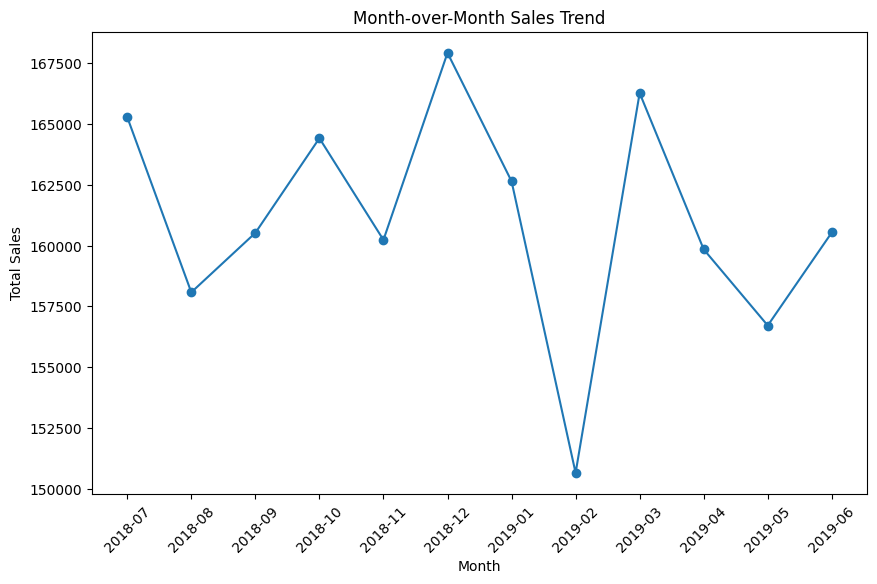

In [27]:
# Execute the SQL query
mom_sales = pd.read_sql(
    "SELECT DATE_FORMAT(DATE, '%%Y-%%m') AS month, SUM(TOT_SALES) AS total_sales "
    "FROM quantium "
    "GROUP BY month "
    "ORDER BY month;",
    engine
)

# Plot the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mom_sales['month'], mom_sales['total_sales'], marker='o')
plt.title('Month-over-Month Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()



December has the highest sales and February the lowest.

3.2 High and Low performing stores

In [28]:
# Load store-level sales data
store_sales = pd.read_sql("SELECT STORE_NBR, SUM(TOT_SALES) AS total_sales FROM quantium GROUP BY STORE_NBR ORDER BY total_sales DESC;", engine)

# Calculate median sales in Python
mean_sales = store_sales['total_sales'].mean()

# Assume store_sales is a DataFrame with columns 'STORE_NBR' and 'total_sales'
top_n = 10
bottom_n = 10

# Sort the DataFrame by total sales
store_sales_sorted = store_sales.sort_values(by='total_sales', ascending=False)

store_sales_sorted.to_csv("output.csv", index=False)


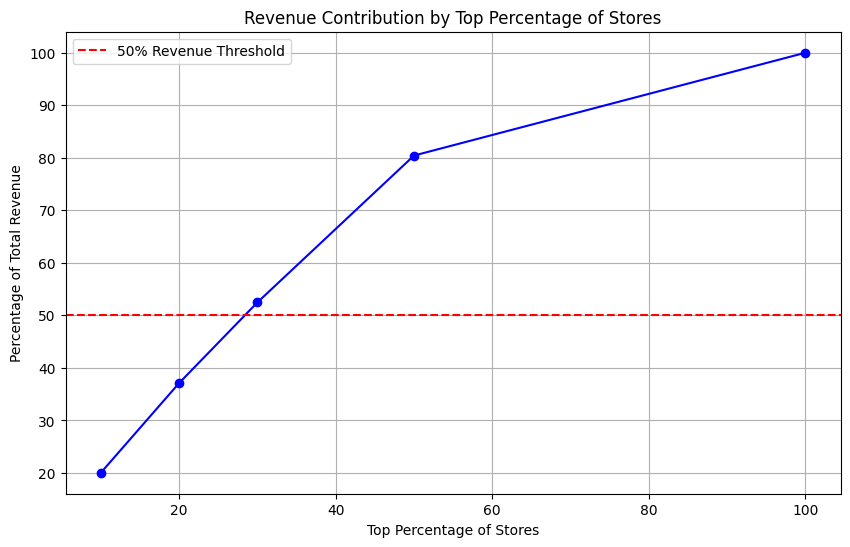

,percentage_threshold,num_stores,revenue,percentage_contribution
0,10,27,387449.70,20.042827
1,20,54,717516.05,37.117206
2,30,81,1014476.35,52.479004
3,50,136,1554678.15,80.423719
4,100,272,1933109.00,100.000000


In [29]:
# Calculate total revenue
total_revenue = store_sales_sorted['total_sales'].sum()

# Define percentage thresholds (e.g., top 10%, 20%, etc.)
percentage_thresholds = [10, 20, 30, 50, 100]

# Calculate the revenue contribution for each percentage threshold
threshold_data = []

for percentage in percentage_thresholds:
    # Calculate the number of stores corresponding to the percentage threshold
    num_stores = int(len(store_sales_sorted) * (percentage / 100))
    top_stores = store_sales_sorted.head(num_stores)
    revenue_contribution = top_stores['total_sales'].sum()
    percentage_contribution = (revenue_contribution / total_revenue) * 100

    threshold_data.append({
        'percentage_threshold': percentage,
        'num_stores': num_stores,
        'revenue': revenue_contribution,
        'percentage_contribution': percentage_contribution
    })

# Convert the threshold data to a DataFrame for visualization
threshold_df = pd.DataFrame(threshold_data)

# Visualize the revenue contribution by percentage thresholds
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['percentage_threshold'], threshold_df['percentage_contribution'], marker='o', linestyle='-', color='blue')
plt.title("Revenue Contribution by Top Percentage of Stores")
plt.xlabel("Top Percentage of Stores")
plt.ylabel("Percentage of Total Revenue")
plt.axhline(50, color='red', linestyle='--', label='50% Revenue Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Print the data for clarity
threshold_df

The top 50% of stores contribute 80% of the revenue.

3.3 Popular v Unpopular Brands

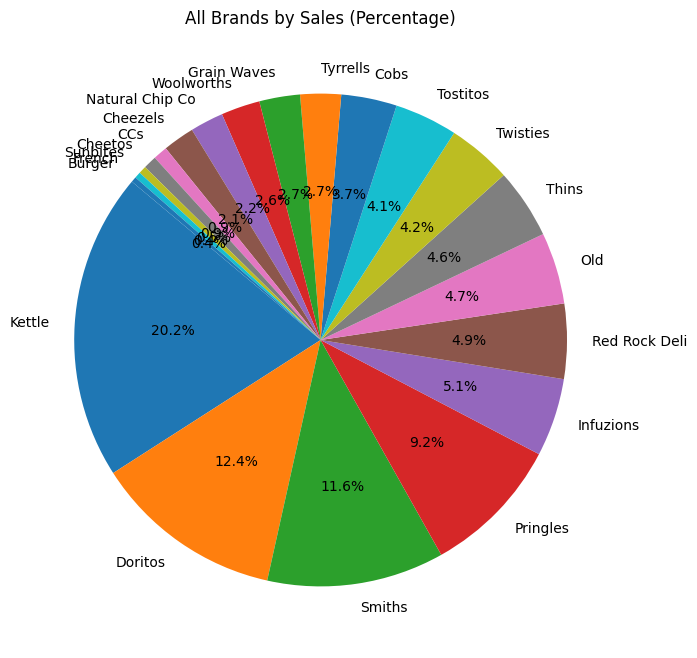

In [30]:
# Load product sales data
product_sales = pd.read_sql("SELECT BRAND_NAME, SUM(TOT_SALES) AS total_sales FROM quantium GROUP BY BRAND_NAME ORDER BY total_sales DESC;", engine)

# Calculate percentages for all brands
product_sales['percentage'] = (product_sales['total_sales'] / product_sales['total_sales'].sum()) * 100

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    product_sales['percentage'], 
    labels=product_sales['BRAND_NAME'], 
    autopct='%1.1f%%', 
    startangle=140
)
plt.title('All Brands by Sales (Percentage)')
plt.show()



C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\1340547450.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20')  # Replace 'tab20' with your preferred colormap


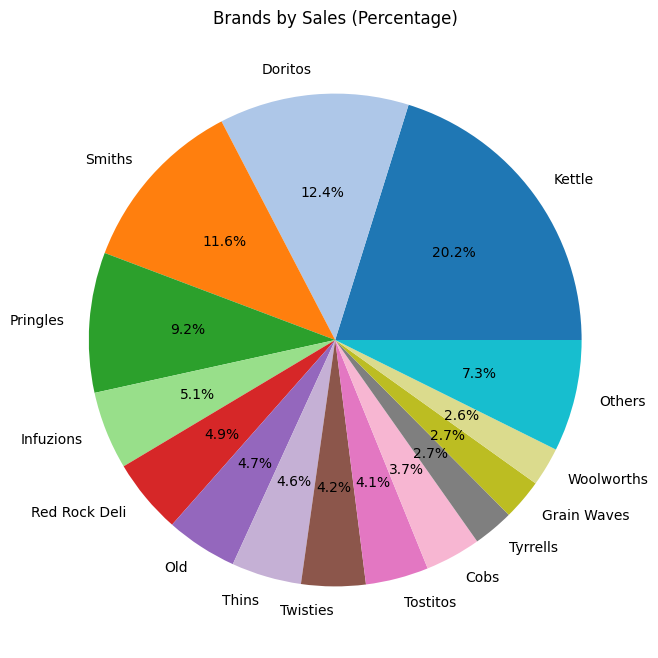

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load product sales data
product_sales = pd.read_sql("SELECT BRAND_NAME, SUM(TOT_SALES) AS total_sales FROM quantium GROUP BY BRAND_NAME ORDER BY total_sales DESC;", engine)

# Calculate percentages for all brands
product_sales['percentage'] = (product_sales['total_sales'] / product_sales['total_sales'].sum()) * 100

# Define the percentage threshold
threshold = 2.5
# Filter rows based on the threshold
above_threshold = product_sales[product_sales['percentage'] >= threshold]
below_threshold = product_sales[product_sales['percentage'] < threshold]

# Combine "Others"
other_row = pd.DataFrame({
    'BRAND_NAME': ['Others'],
    'total_sales': [below_threshold['total_sales'].sum()],
    'percentage': [below_threshold['percentage'].sum()]
})

# Combine the dataframes
product_sales_combined = pd.concat([above_threshold, other_row], ignore_index=True)

# Generate a colormap
colormap = cm.get_cmap('tab20')  # Replace 'tab20' with your preferred colormap
colors = [colormap(i / len(product_sales_combined)) for i in range(len(product_sales_combined))]

# Create the pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    product_sales_combined['percentage'], 
    labels=product_sales_combined['BRAND_NAME'], 
    autopct='%1.1f%%', 
    colors=colors
)
plt.title('Brands by Sales (Percentage)')
plt.show()



We can see that four brands - Kettle, Doritos, Smiths and Pringles contribute to more than 50% of the total sales. Kettle is the most popular brand.

Let us now move on to Customer Analysis.

4.1 Repeat Customers Proportion

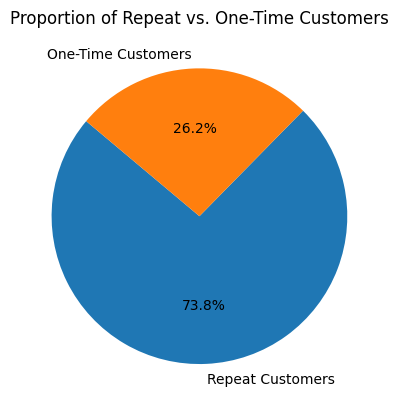

In [32]:
# Query to calculate repeat customers
query_repeat_customers = """
SELECT 
    COUNT(DISTINCT LYLTY_CARD_NBR) AS total_customers,
    COUNT(DISTINCT CASE WHEN txn_count > 1 THEN LYLTY_CARD_NBR END) AS repeat_customers,
    COUNT(DISTINCT CASE WHEN txn_count = 1 THEN LYLTY_CARD_NBR END) AS one_time_customers
FROM (
    SELECT 
        LYLTY_CARD_NBR, 
        COUNT(*) AS txn_count
    FROM quantium
    GROUP BY LYLTY_CARD_NBR
) AS customer_txns;
"""

# Load results into Python
repeat_customers = pd.read_sql(query_repeat_customers, engine)

# Calculate proportions
total_customers = repeat_customers['total_customers'][0]
repeat_prop = repeat_customers['repeat_customers'][0] / total_customers * 100
one_time_prop = repeat_customers['one_time_customers'][0] / total_customers * 100

# Visualize
labels = ['Repeat Customers', 'One-Time Customers']
sizes = [repeat_prop, one_time_prop]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Repeat vs. One-Time Customers')
plt.show()


73.8% customers are repeat customers.

4.2 Customer distribution and performance by 'Lifestage' and 'Premium' level

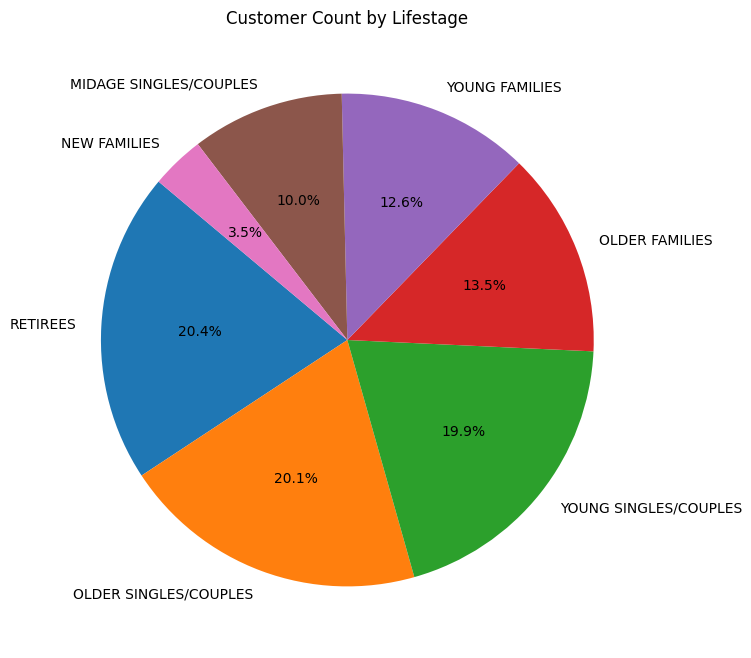

In [33]:
query_lifestyle = """
SELECT 
    LIFESTAGE,
    COUNT(DISTINCT LYLTY_CARD_NBR) AS customer_count
FROM quantium
GROUP BY LIFESTAGE
ORDER BY customer_count DESC;
"""
customer_count = pd.read_sql(query_lifestyle, engine)

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    customer_count['customer_count'], 
    labels=customer_count['LIFESTAGE'], 
    autopct='%1.1f%%',  # Show percentages
    startangle=140,  # Rotate the chart for better visual
)
plt.title('Customer Count by Lifestage')
plt.show()


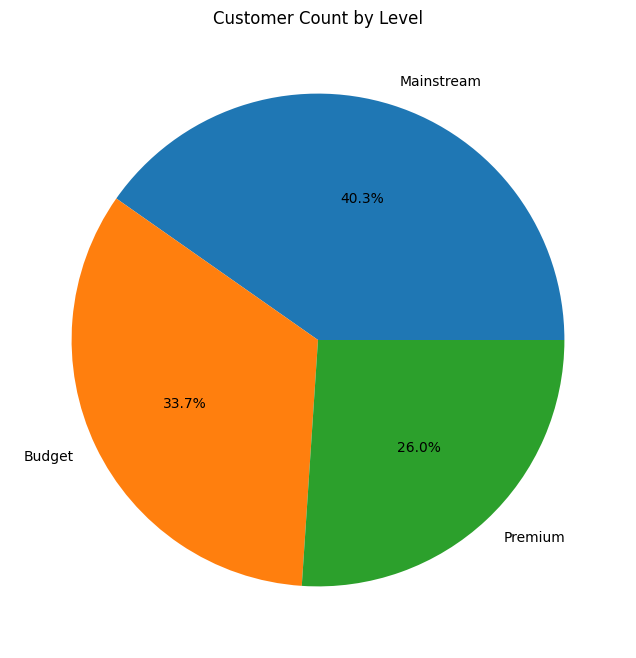

In [34]:
query_premium = """
SELECT 
    PREMIUM_CUSTOMER,
    COUNT(DISTINCT LYLTY_CARD_NBR) AS customer_count
FROM quantium
GROUP BY PREMIUM_CUSTOMER
ORDER BY customer_count DESC;
"""
customer_count = pd.read_sql(query_premium, engine)

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    customer_count['customer_count'], 
    labels=customer_count['PREMIUM_CUSTOMER'], 
    autopct='%1.1f%%',  # Show percentages
)
plt.title('Customer Count by Level')
plt.show()

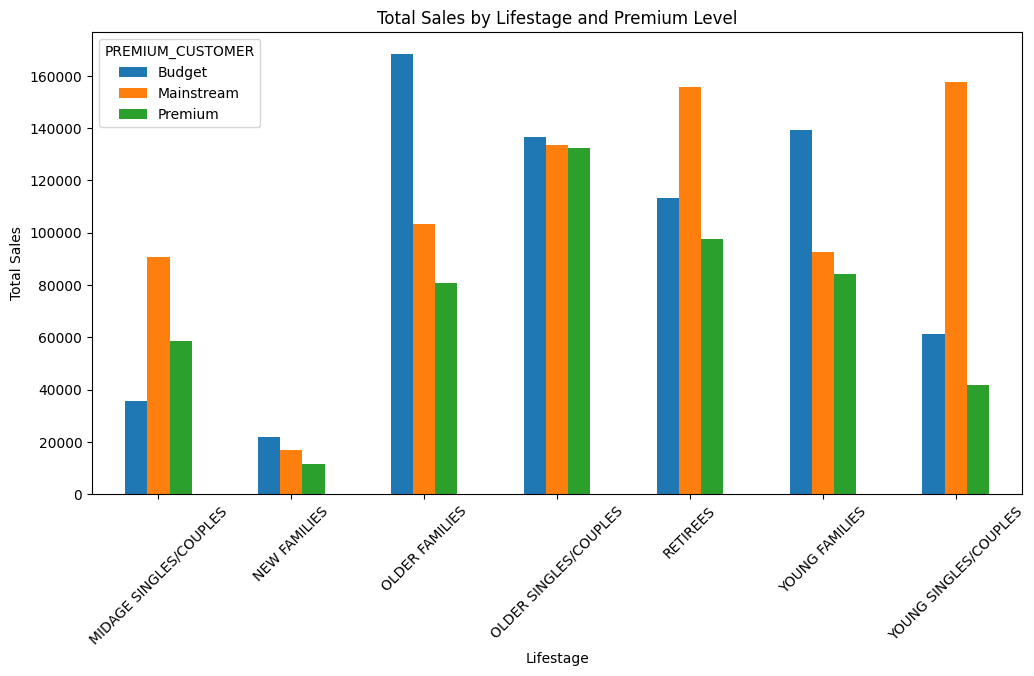

In [35]:
# Query to calculate customer performance by Lifestage and Premium level
query_customer_perf = """
SELECT 
    LIFESTAGE,
    PREMIUM_CUSTOMER,
    COUNT(DISTINCT LYLTY_CARD_NBR) AS customer_count,
    SUM(TOT_SALES) AS total_sales,
    AVG(TOT_SALES) AS avg_sales_per_customer,
    SUM(PROD_QTY) AS total_quantity,
    AVG(PROD_QTY) AS avg_quantity_per_customer
FROM quantium
GROUP BY LIFESTAGE, PREMIUM_CUSTOMER
ORDER BY total_sales DESC;
"""

# Load results into Python
customer_perf = pd.read_sql(query_customer_perf, engine)

# Visualize total sales by Lifestage and Premium level
customer_perf.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='total_sales').plot(kind='bar', figsize=(12, 6))
plt.title('Total Sales by Lifestage and Premium Level')
plt.ylabel('Total Sales')
plt.xlabel('Lifestage')
plt.xticks(rotation=45)
plt.show()


The main contributors to sales are the Budget-Older Families, Mainstream-Young Singles/Couples and Mainstream-Retirees customer segments. Let us investigate this further. Do these segments have more customers?

In [36]:
customer_perf

,LIFESTAGE,PREMIUM_CUSTOMER,customer_count,total_sales,avg_sales_per_customer,total_quantity,avg_quantity_per_customer
0,OLDER FAMILIES,Budget,4675,168363.25,7.269570,45065.0,1.9458
1,YOUNG SINGLES/COUPLES,Mainstream,8088,157621.60,7.558339,38632.0,1.8525
2,RETIREES,Mainstream,6479,155677.05,7.252262,40518.0,1.8875
3,YOUNG FAMILIES,Budget,4017,139345.85,7.287201,37111.0,1.9407
4,OLDER SINGLES/COUPLES,Budget,4929,136769.80,7.430315,35220.0,1.9134
5,OLDER SINGLES/COUPLES,Mainstream,4930,133393.80,7.282116,34997.0,1.9105
6,OLDER SINGLES/COUPLES,Premium,4750,132257.15,7.449848,33984.0,1.9143
7,RETIREES,Budget,4454,113147.80,7.443445,28764.0,1.8922
8,OLDER FAMILIES,Mainstream,2831,103445.55,7.262395,27756.0,1.9486
9,RETIREES,Premium,3872,97646.05,7.456174,24884.0,1.9001


In [37]:
customer_perf.describe()

,customer_count,total_sales,avg_sales_per_customer,total_quantity,avg_quantity_per_customer
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,3458.857143,92052.809524,7.251513,24034.380952,1.895352
std,1860.374137,48681.006152,0.250790,12575.962752,0.043584
min,588.000000,11491.100000,6.615624,2957.000000,1.803800
25%,2431.000000,58432.650000,7.208079,15526.000000,1.860900
50%,3340.000000,92788.750000,7.269570,24884.000000,1.900100
75%,4675.000000,133393.800000,7.430315,34997.000000,1.937700
max,8088.000000,168363.250000,7.647284,45065.000000,1.948600


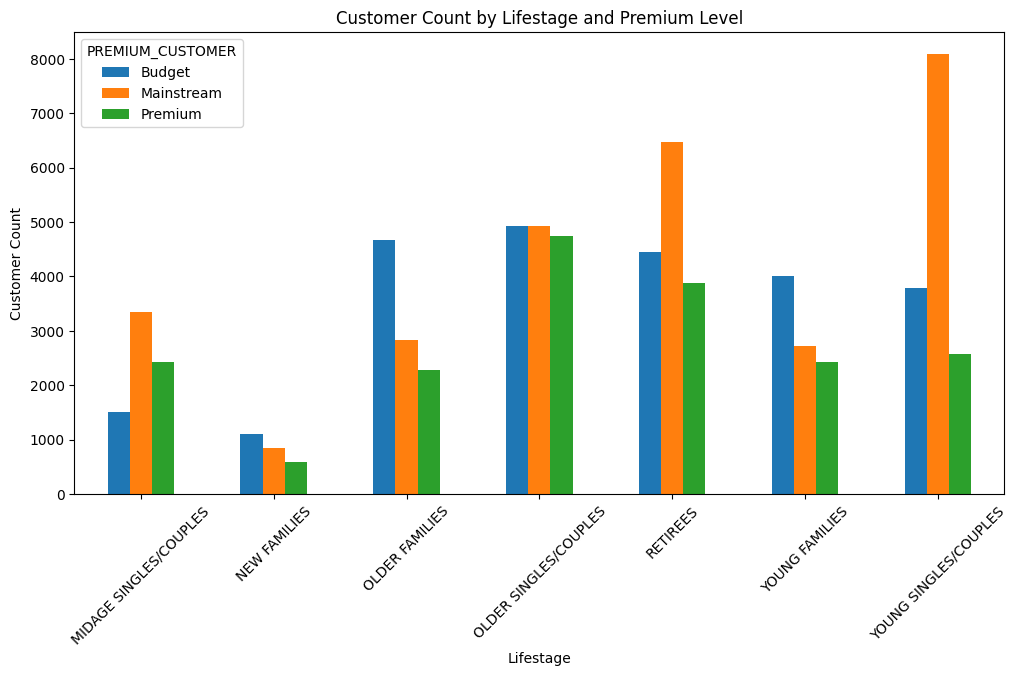

In [38]:
query_customer_count = """
SELECT 
    LIFESTAGE,
    PREMIUM_CUSTOMER,
    COUNT(DISTINCT LYLTY_CARD_NBR) AS customer_count
FROM quantium
GROUP BY LIFESTAGE, PREMIUM_CUSTOMER
ORDER BY customer_count DESC;
"""

# Load results into Python
customer_count = pd.read_sql(query_customer_count, engine)

# Visualize customer count by Lifestage and Premium level
customer_count.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='customer_count').plot(kind='bar', figsize=(12, 6))
plt.title('Customer Count by Lifestage and Premium Level')
plt.ylabel('Customer Count')
plt.xlabel('Lifestage')
plt.xticks(rotation=45)
plt.show()



There are more Mainstream-Young Singles/Couples and Mainstream-Retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget-Older families segment.We can investigate this further.

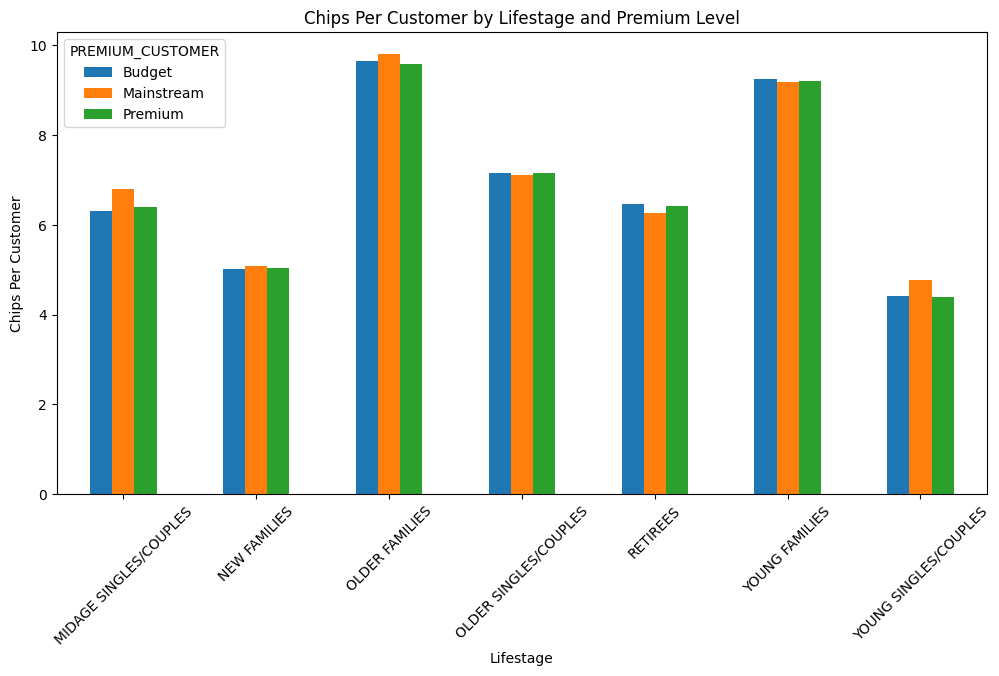

In [39]:
# Query to calculate chips per customer by Lifestage and Premium level
query_chips_per_customer = """
SELECT 
    LIFESTAGE,
    PREMIUM_CUSTOMER,
    SUM(PROD_QTY) AS total_quantity,
    COUNT(DISTINCT LYLTY_CARD_NBR) AS customer_count,
    SUM(PROD_QTY) * 1.0 / COUNT(DISTINCT LYLTY_CARD_NBR) AS chips_per_customer
FROM quantium
GROUP BY LIFESTAGE, PREMIUM_CUSTOMER
ORDER BY chips_per_customer DESC;
"""

# Load results into Python
chips_per_customer = pd.read_sql(query_chips_per_customer, engine)

# Visualize chips per customer by Lifestage and Premium level
chips_per_customer.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='chips_per_customer').plot(kind='bar', figsize=(12, 6))
plt.title('Chips Per Customer by Lifestage and Premium Level')
plt.ylabel('Chips Per Customer')
plt.xlabel('Lifestage')
plt.xticks(rotation=45)
plt.show()


It appears that older families and young families buy more chips per customer.

4.3 RFM Analysis

Let's check the recency.

In [40]:
recency_query = """
WITH recency AS (
    SELECT 
        LYLTY_CARD_NBR,
        MAX(DATE) AS last_purchase_date
    FROM quantium
    GROUP BY LYLTY_CARD_NBR
)
SELECT 
    q.LIFESTAGE,
    q.PREMIUM_CUSTOMER,
    AVG(DATEDIFF('2019-06-30', r.last_purchase_date)) AS average_recency
FROM recency r
JOIN quantium q
ON r.LYLTY_CARD_NBR = q.LYLTY_CARD_NBR
GROUP BY q.LIFESTAGE, q.PREMIUM_CUSTOMER
ORDER BY average_recency ASC;
"""

# Execute the query and load results into a DataFrame
rec = pd.read_sql(recency_query, engine)

# Display the results
print(rec)

                 LIFESTAGE PREMIUM_CUSTOMER  average_recency
0           YOUNG FAMILIES          Premium          54.7368
1           OLDER FAMILIES           Budget          55.0066
2           OLDER FAMILIES       Mainstream          55.4686
3           OLDER FAMILIES          Premium          56.1628
4           YOUNG FAMILIES           Budget          56.5919
5           YOUNG FAMILIES       Mainstream          59.0041
6    OLDER SINGLES/COUPLES       Mainstream          70.5764
7    OLDER SINGLES/COUPLES          Premium          70.6424
8    OLDER SINGLES/COUPLES           Budget          71.1079
9   MIDAGE SINGLES/COUPLES       Mainstream          73.6743
10  MIDAGE SINGLES/COUPLES          Premium          74.7023
11                RETIREES       Mainstream          76.4615
12  MIDAGE SINGLES/COUPLES           Budget          76.6811
13                RETIREES           Budget          77.0197
14                RETIREES          Premium          78.3542
15            NEW FAMILI

Older families of all levels have made most recent purchases followed by young families.

Now the frequency.

In [41]:
freq_query = """
WITH freq AS (
    SELECT 
        lylty_card_nbr, 
        COUNT(txn_id) AS frequency
    FROM quantium
    GROUP BY lylty_card_nbr
)
SELECT 
    q.premium_customer, 
    q.lifestage, 
    AVG(freq.frequency) AS avg_frequency
FROM freq
JOIN quantium AS q
ON freq.lylty_card_nbr = q.lylty_card_nbr
GROUP BY q.premium_customer, q.lifestage
ORDER BY avg_frequency DESC;"""

freq = pd.read_sql(freq_query, engine)

# Display the results
print(freq)

   premium_customer               lifestage  avg_frequency
0        Mainstream          OLDER FAMILIES         7.2352
1            Budget          OLDER FAMILIES         7.1614
2           Premium          OLDER FAMILIES         7.0895
3            Budget          YOUNG FAMILIES         7.0066
4           Premium          YOUNG FAMILIES         6.9972
5        Mainstream          YOUNG FAMILIES         6.9208
6           Premium   OLDER SINGLES/COUPLES         5.2028
7            Budget   OLDER SINGLES/COUPLES         5.1973
8        Mainstream   OLDER SINGLES/COUPLES         5.1905
9        Mainstream  MIDAGE SINGLES/COUPLES         5.1822
10          Premium  MIDAGE SINGLES/COUPLES         5.1315
11           Budget  MIDAGE SINGLES/COUPLES         4.9562
12           Budget                RETIREES         4.7541
13          Premium                RETIREES         4.7173
14       Mainstream                RETIREES         4.6619
15       Mainstream   YOUNG SINGLES/COUPLES         3.98

Older families have made more frequent purchases as well, followed by young families.

Let us proceed with RFM segmentation.

In [42]:
base_rfm_query = """
SELECT 
    lylty_card_nbr,
    DATEDIFF('2019-06-30', MAX(date)) AS recency,
    COUNT(txn_id) AS frequency,
    ROUND(SUM(tot_sales)) AS monetary,
    NTILE(5) OVER (ORDER BY DATEDIFF('2019-06-30', MAX(date)) DESC) AS recency_q,
    NTILE(5) OVER (ORDER BY COUNT(txn_id)) AS frequency_q,
    NTILE(5) OVER (ORDER BY ROUND(SUM(tot_sales))) AS monetary_q
FROM quantium
GROUP BY lylty_card_nbr;
"""
rfm = pd.read_sql(base_rfm_query, engine)

def assign_segment(row):
    if row['recency_q'] == 5 and row['frequency_q'] >= 4:
        return 'Champions'
    elif row['recency_q'] >= 3 and row['frequency_q'] >= 4:
        return 'Potential Loyalists'
    elif row['recency_q'] >= 3 and row['frequency_q'] == 3:
        return 'Promising'
    elif row['recency_q'] >= 4 and row['frequency_q'] <= 2:
        return 'New'
    elif row['recency_q'] == 3 and row['frequency_q'] <= 2:
        return 'About to Sleep'
    elif row['recency_q'] <= 2 and row['frequency_q'] >= 4:
        return 'Cannot Lose'
    elif row['recency_q'] <= 2 and row['frequency_q'] >= 2:
        return 'At Risk'
    else:
        return 'Hibernating'

rfm['segment'] = rfm.apply(assign_segment, axis=1)

In [43]:
rfm

,lylty_card_nbr,recency,frequency,monetary,recency_q,frequency_q,monetary_q,segment
0,136239,140,1,2.0,2,2,1,At Risk
1,233221,140,1,2.0,2,2,1,At Risk
2,233296,140,1,2.0,2,2,1,At Risk
3,195474,139,1,2.0,2,2,1,At Risk
4,249246,139,1,2.0,2,2,1,At Risk
...,...,...,...,...,...,...,...,...
72631,58361,5,14,125.0,5,5,5,Champions
72632,259009,59,15,127.0,3,5,5,Potential Loyalists
72633,162039,9,18,127.0,5,5,5,Champions
72634,63197,0,15,133.0,5,5,5,Champions


In [44]:
rfm.describe()

,lylty_card_nbr,recency,frequency,monetary,recency_q,frequency_q,monetary_q
count,7.263600e+04,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000,72636.000000
mean,1.361847e+05,104.645520,3.646030,26.614902,2.999972,2.999972,2.999972
std,8.989293e+04,93.306151,2.630113,20.267347,1.414233,1.414233,1.414233
min,1.000000e+03,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,6.620175e+04,29.000000,1.000000,9.000000,2.000000,2.000000,2.000000
50%,1.340395e+05,75.000000,3.000000,22.000000,3.000000,3.000000,3.000000
75%,2.033742e+05,158.000000,5.000000,40.000000,4.000000,4.000000,4.000000
max,2.373711e+06,364.000000,18.000000,139.000000,5.000000,5.000000,5.000000


In [45]:
segment_stats = rfm.groupby('segment').agg(
    count=('segment', 'size'),
    amv=('monetary', 'mean'),  
    arv=('recency', 'mean'),
    afv=('frequency', 'mean'),
    arq=('recency_q', 'mean'),
    afq=('frequency_q', 'mean'),
    amq=('monetary_q', 'mean')
).reset_index()

segment_stats['percentage'] = (segment_stats['count'] / segment_stats['count'].sum()) * 100

segment_stats['amv'] = np.ceil(segment_stats['amv'])
segment_stats['arv'] = np.ceil(segment_stats['arv'])
segment_stats['afv'] = np.ceil(segment_stats['afv'])
segment_stats['arq'] = np.ceil(segment_stats['arq'])
segment_stats['afq'] = np.ceil(segment_stats['afq'])
segment_stats['amq'] = np.ceil(segment_stats['amq'])
segment_stats['percentage'] = np.ceil(segment_stats['percentage'])


print(segment_stats)

               segment  count   amv    arv  afv  arq  afq  amq  percentage
0       About to Sleep   2860   8.0   81.0  2.0  3.0  2.0  2.0         4.0
1              At Risk  16572  16.0  188.0  3.0  2.0  3.0  3.0        23.0
2          Cannot Lose   3359  44.0  149.0  6.0  2.0  5.0  5.0         5.0
3            Champions  10002  50.0   11.0  7.0  5.0  5.0  5.0        14.0
4          Hibernating   9124   7.0  241.0  1.0  2.0  1.0  2.0        13.0
5                  New   5581  10.0   25.0  2.0  5.0  2.0  2.0         8.0
6  Potential Loyalists  15693  46.0   53.0  7.0  4.0  5.0  5.0        22.0
7            Promising   9445  20.0   53.0  3.0  4.0  3.0  3.0        14.0


In [46]:
segment_stats.to_csv("output.csv", index=False)

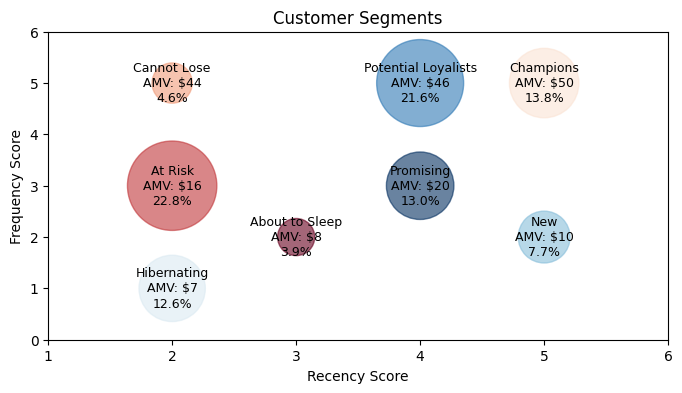

In [47]:
plt.figure(figsize=(8, 4))
bubble_chart = plt.scatter(
    segment_stats['arq'],  
    segment_stats['afq'],
    s=segment_stats['count']*0.25, 
    alpha=0.6, 
    c=range(len(segment_stats)),  
    cmap='RdBu'
)

for i, row in segment_stats.iterrows():
    plt.text(
        row['arq'], 
        row['afq'], 
        f"{row['segment']}\nAMV: ${row['amv']:.0f}\n{row['count'] / segment_stats['count'].sum() * 100:.1f}%",
        fontsize=9, ha='center', va='center'
    )

# Add axis labels, title, and grid
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.title('Customer Segments')
plt.grid(False)

# Set x and y ticks to increments of 1
x_ticks = np.arange(segment_stats['arq'].min() - 1, segment_stats['arq'].max() + 2, 1)
y_ticks = np.arange(segment_stats['afq'].min() - 1, segment_stats['afq'].max() + 2, 1)
plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.show()


5.1 A/B Testing

First we need to prepare dataset and add metrics of interest. Let's begin by adding month and year.

In [48]:
abtest = combined.copy()

abtest['YEARMONTH'] = abtest['DATE'].dt.strftime('%Y%m').astype('int64')
abtest

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND_NAME,PACK_SIZE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,Natural Chip Co,175.0,2,6.0,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,CCs,175.0,3,6.3,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,Smiths,170.0,2,2.9,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,Smiths,175.0,5,15.0,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,Kettle,150.0,3,13.8,MIDAGE SINGLES/COUPLES,Budget,201808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264828,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,Kettle,175.0,2,10.8,YOUNG SINGLES/COUPLES,Premium,201903
264829,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,Tostitos,175.0,1,4.4,YOUNG SINGLES/COUPLES,Premium,201808
264830,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,Doritos,170.0,2,8.8,YOUNG SINGLES/COUPLES,Premium,201811
264831,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,Doritos,150.0,2,7.8,YOUNG SINGLES/COUPLES,Premium,201812


Now let's create the key metrics and filter data.

In [49]:
# Define the metrics and calculate them
grouped_df = abtest.groupby(["STORE_NBR","YEARMONTH"])
tot_sales = grouped_df.TOT_SALES.sum()
n_cust = grouped_df.LYLTY_CARD_NBR.nunique()
ntrans_percust = grouped_df.TXN_ID.size()/n_cust
nchips_pertrans = grouped_df.PROD_QTY.sum()/grouped_df.TXN_ID.size()
avg_priceperunit = tot_sales/grouped_df.PROD_QTY.sum()

# Put the metrics together in an array
metric_arrays =  [tot_sales, n_cust, ntrans_percust, nchips_pertrans, avg_priceperunit]

# Create the metrics table fro mthe array 
metrics_df = pd.concat(metric_arrays, axis=1)
# Give the columns labels 
metrics_df.columns = ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit']
metrics_df = metrics_df.reset_index()

# Filter to select the stores with full observation periods 
month_counts = metrics_df.groupby('STORE_NBR').YEARMONTH.nunique().reset_index()
stores_fullobs = month_counts[month_counts.YEARMONTH ==12].STORE_NBR
pretrial_metrics = metrics_df[metrics_df['STORE_NBR'].isin(stores_fullobs)]

# Then filter to keep only the pre-trial period data
pretrial_metrics = pretrial_metrics.loc[pretrial_metrics.YEARMONTH < 201902]
pretrial_metrics

,STORE_NBR,YEARMONTH,tot_sales,n_cust,ntrans_percust,nchips_pertrans,avg_priceperunit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.159091,1.941176,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


Now we have to select control stores. For this we need to determine correlations between stores first.

In [50]:
def calc_corr(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)] 
    
    trial_vals = input_table[input_table["STORE_NBR"] == trial][metric_col].reset_index()
    corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation']) 
 
    for control in control_stores:
        control_vals = input_table[input_table["STORE_NBR"] == control][metric_col].reset_index()
        corr_row = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
        corr_row.YEARMONTH = list(input_table.loc[input_table.STORE_NBR == control]["YEARMONTH"])
        corr_row.trial_store = trial
        corr_row.control_store = control
        corr_row.correlation = control_vals.corrwith(trial_vals, method='pearson', axis=1)
        corr_table = pd.concat([corr_table, corr_row])
    return (corr_table)

trial_stores = [77, 86, 88]

corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
for store in trial_stores:
    corr_section = calc_corr(store, ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit'] )
    corr_table = pd.concat([corr_table, corr_section])

corr_table


C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_section])
C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a futur

,YEARMONTH,trial_store,control_store,correlation
0,201807,77,1,0.070544
1,201808,77,1,0.027332
2,201809,77,1,0.002472
3,201810,77,1,-0.019991
4,201811,77,1,0.030094
...,...,...,...,...
2,201809,88,272,0.533160
3,201810,88,272,0.591056
4,201811,88,272,0.566378
5,201812,88,272,0.594442


We have determined correlation using Pearson's coefficient, now we will use distance magnitude.

In [51]:
def calc_magdist(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)] 
    dist_table = pd.DataFrame() 
    for control in control_stores: 
        dist_row = pd.DataFrame()
        
        dist_row = abs(input_table[input_table["STORE_NBR"] == trial].reset_index()[metric_col]\
                        - input_table[input_table["STORE_NBR"] == control].reset_index()[metric_col])
        dist_row.insert(0,'YEARMONTH', list(input_table.loc[input_table.STORE_NBR == trial]["YEARMONTH"]))
        dist_row.insert(1,'trial_store', trial)
        dist_row.insert(2,'control_store', control)
        dist_table = pd.concat([dist_table, dist_row])
        
    for col in metric_col: 
        maxdist = dist_table[col].max()
        mindist = dist_table[col].min()
        dist_table[col] = 1-(dist_table[col] - mindist)/(maxdist-mindist) 
        
    dist_table['mag_measure'] = dist_table[metric_col].mean(axis=1)  
    return (dist_table)

Next we will combine these two scores.

In [52]:
def calc_corrdist_score (trial, metric_col, input_table=pretrial_metrics):
    
    corr_vals = calc_corr(trial, metric_col, input_table)
    mag_vals = calc_magdist(trial, metric_col, input_table)
    mag_vals = mag_vals.drop(metric_col, axis=1) 
    
   
    combined_corr_dist = pd.merge(corr_vals, mag_vals, on=["YEARMONTH", "trial_store", "control_store"])
    
    # Average correlations and distances over the pre-trial months 
    avg_corrmag = combined_corr_dist.groupby(["trial_store", "control_store"]).mean().reset_index()
    
    # Find a combined score by taking the weighted average of the correlations and magnitudes 
    corr_weight = 0.5
    avg_corrmag['combined_score'] = corr_weight*avg_corrmag['correlation'] + (1-corr_weight)*avg_corrmag['mag_measure']
    
    return(avg_corrmag)

We’ll select control stores based on how similar monthly total sales and number of customers are to the trial stores.

In [53]:
def find_highestscore(trial):
    
    scores_tot_sales = calc_corrdist_score (trial, ['tot_sales'])
    scores_n_cust = calc_corrdist_score (trial, ['n_cust'])
  
    scores_control = pd.DataFrame()
    scores_control['control_store'] = scores_tot_sales.control_store
   
    scores_control['correlation'] = 0.5*scores_tot_sales.correlation + 0.5*scores_n_cust.correlation
    scores_control['mag_measure'] = 0.5*scores_tot_sales.mag_measure + 0.5*scores_n_cust.mag_measure
    scores_control['scores'] = 0.5*scores_tot_sales.combined_score + 0.5*scores_n_cust.combined_score
    return(scores_control.sort_values(by = 'scores', ascending = False).reset_index(drop = True).head(5))

trial_stores = [77, 86, 88]

for trial in trial_stores:
    print('Trial store: ', trial)
    print(find_highestscore(trial))
    print()

Trial store:  77


C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])


   control_store  correlation  mag_measure    scores
0            233          1.0     0.989804  0.994902
1             41          1.0     0.972041  0.986020
2             46          1.0     0.969523  0.984762
3             53          1.0     0.968421  0.984211
4            111          1.0     0.967981  0.983991

Trial store:  86


C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])


   control_store  correlation  mag_measure    scores
0            155          1.0     0.976324  0.988162
1            109          1.0     0.968180  0.984090
2            225          1.0     0.965044  0.982522
3            229          1.0     0.957995  0.978997
4            101          1.0     0.945394  0.972697

Trial store:  88


C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])
C:\Users\saabi\AppData\Local\Temp\ipykernel_49368\272281001.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row])


   control_store  correlation  mag_measure    scores
0             40          1.0     0.941789  0.970895
1             26          1.0     0.917859  0.958929
2             72          1.0     0.908157  0.954079
3             58          1.0     0.900435  0.950217
4             81          1.0     0.887572  0.943786



So for store 77 the control store is 233. 
For store 86 it is 155.
For store 88 it is 40.

Let's perform visual checks on trial and control stores.

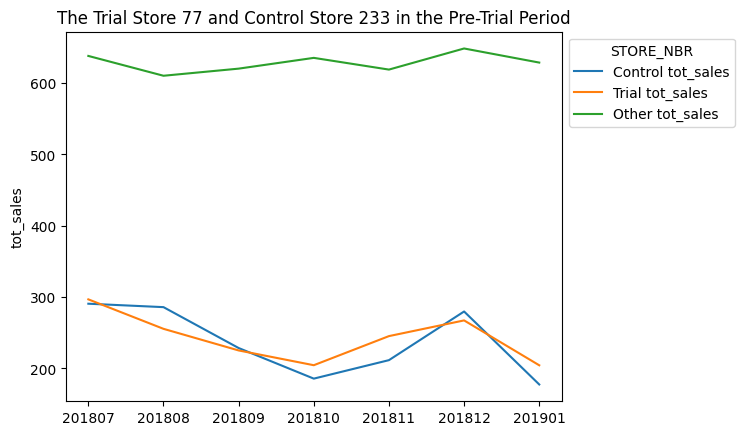

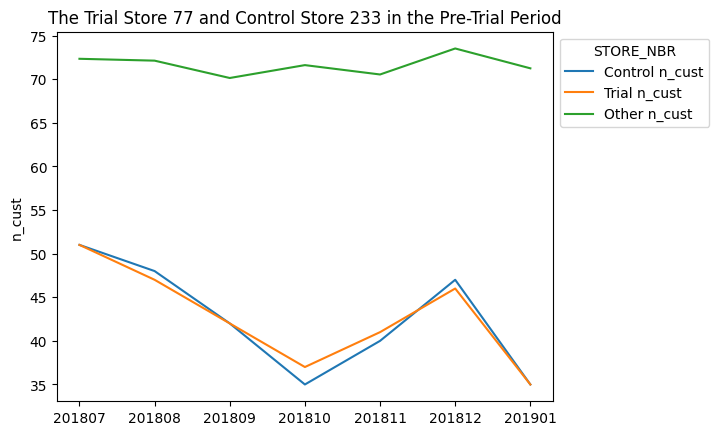

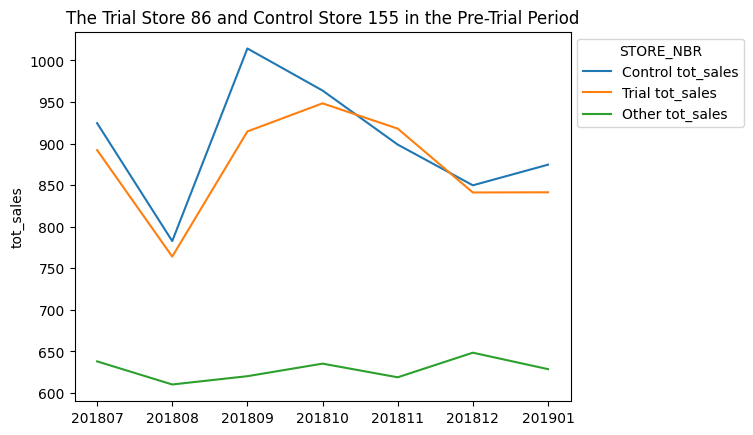

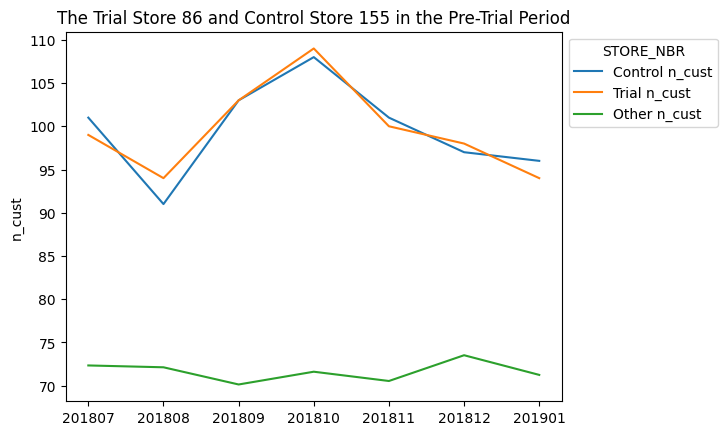

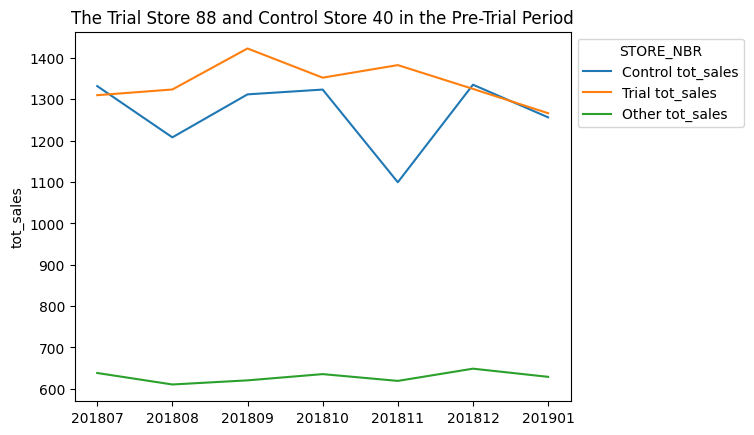

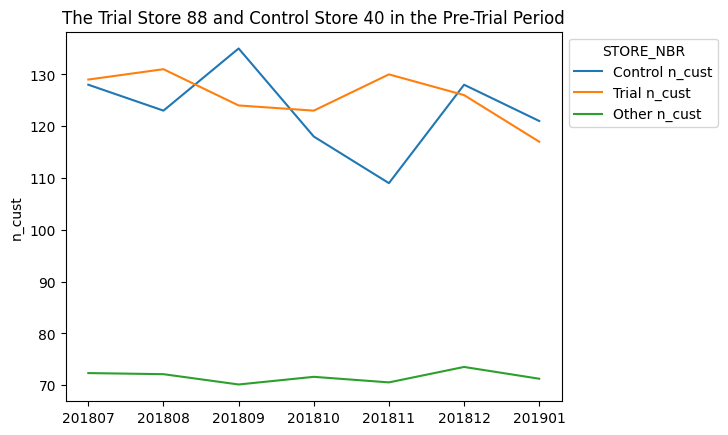

In [54]:
def make_plots(storepair, metric_col):
    trial = storepair[0]
    control = storepair[1]
    trial_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == trial][['YEARMONTH', 'STORE_NBR', metric_col]]
    trial_plot = trial_plot.rename(columns = {metric_col: metric_col+'_trial'})
    control_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == control][['YEARMONTH', 'STORE_NBR', metric_col]]
    control_plot = control_plot.rename(columns = {metric_col: metric_col+'_control'})
    
    other_stores = pretrial_metrics.loc[(pretrial_metrics.STORE_NBR != 77)][['YEARMONTH', 'STORE_NBR', metric_col]]
    other_stores = other_stores.loc[(pretrial_metrics.STORE_NBR != 233)]
    plot_other = other_stores.groupby('YEARMONTH')[metric_col].mean()

    ax = control_plot.plot.line(x = "YEARMONTH", y = metric_col+'_control', use_index=False, label = 'Control '+metric_col)
    ax_trial = trial_plot.plot.line(x = "YEARMONTH", y = metric_col+'_trial', use_index=False, ax=ax, label = 'Trial '+metric_col)
    ax_other = plot_other.plot.line(use_index = False, ax=ax, label = 'Other '+ metric_col)
    ax.set_ylabel(metric_col)
    plt.legend(title = 'STORE_NBR', loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    positions = (0,1,2,3,4,5,6)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901')
    plt.xticks (positions, labels)
    titlestr = 'The Trial Store ' + str(storepair[0]) + ' and Control Store ' + str(storepair[1]) + ' in the Pre-Trial Period'
    ax.set_title(titlestr)
    
storepair = [[77, 233], [86, 155], [88, 40]]
metric_col = ['tot_sales', 'n_cust']
for pair in storepair:
    for metric in metric_col:
        make_plots(pair, metric)

The metrics of the control and trial stores look reasonably similar in the pre-trial period.

Now we can assess our trial and see if there has been an uplift in sales and number of customers.

We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period.

In [55]:
# Calculate the scaling factor for the store pairs
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['tot_sales'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['tot_sales'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['tot_sales'].sum()

# Extract the control store data from the df and scale according to the store 
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control233.tot_sales *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control155.tot_sales *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control40.tot_sales *= scale_store88

# Combine the scaled control stores to a single df
scaledsales_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledsales_control = scaledsales_control.rename(columns = {'tot_sales':'scaled_tot_sales', 'STORE_NBR': 'CONTROL_NBR'}) 

# Get the trial period of scaled control stores 
scaledsales_control_trial = scaledsales_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201906)].reset_index(drop = True)

# Get the trial period of the trial stores 
trialsales = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'tot_sales']].reset_index(drop = True)
trialsales = trialsales.rename(columns = {'STORE_NBR': 'TRIAL_NBR'}) 
trialsales_trial = trialsales[(trialsales.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201906)].reset_index(drop = True)

In [56]:
# Calculate the percentage difference between the control and trial store pairs for each month over the year   
percentdiff = scaledsales_control.copy()
percentdiff[['TRIAL_NBR', 'tot_sales_t']] = trialsales[['TRIAL_NBR', 'tot_sales']]
percentdiff = percentdiff.rename(columns = {'scaled_tot_sales' : 'scaled_sales_c'})
percentdiff['sales_percent_diff'] = (percentdiff.tot_sales_t-percentdiff.scaled_sales_c)\
                                    /(0.5*((percentdiff.scaled_sales_c+percentdiff.tot_sales_t)))
percentdiff.sort_values(by='TRIAL_NBR')

,CONTROL_NBR,YEARMONTH,scaled_sales_c,TRIAL_NBR,tot_sales_t,sales_percent_diff
0,233,201807,297.565550,77,296.80,-0.002576
1,233,201808,292.652187,77,255.50,-0.135554
2,233,201809,233.998916,77,225.20,-0.038323
3,233,201810,190.085733,77,204.50,0.073060
4,233,201811,216.597421,77,245.30,0.124281
5,233,201812,286.408121,77,267.30,-0.069019
6,233,201901,181.692071,77,204.40,0.117630
7,233,201902,249.762622,77,235.00,-0.060907
8,233,201903,203.802205,77,278.50,0.309755
9,233,201904,162.345704,77,263.50,0.475075


Now we perform a t-test to check if the difference is statistically significant. Our null hypothesis is that the trial period is the same as the pre-trial period.

In [57]:
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['sales_percent_diff'].agg('std').reset_index()
dof = 6 # 7 months of data - 1 

for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['sales_percent_diff'].agg('std')
    mean =  pretrial['sales_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201906) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['sales_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

# Generate the t-statistic for the 95% percentile with 6 dof
print ('95th percentile value:', t.ppf(1-0.05, 6))  


Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.7171038288055838
201903  :  3.035317928855674
201904  :  4.708944418758219
201905  :  -1.7540503784414865
201906  :  1.486555531503749

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  1.4133618775921597
201903  :  7.123063846042147
201904  :  0.8863824572944234
201905  :  -0.19473107623388683
201906  :  0.18183021262625657

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.5481633746817577
201903  :  1.0089992743637823
201904  :  0.9710006270463672
201905  :  -0.9769183299523407
201906  :  -1.6027471488886815

95th percentile value: 1.9431802805153018


We can observe that the t-value for the trial store 77 is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store 77 in March and April is statistically greater than in the control store. This can also be seen for March of trial store 86.

Let's create visualizations to examine further.

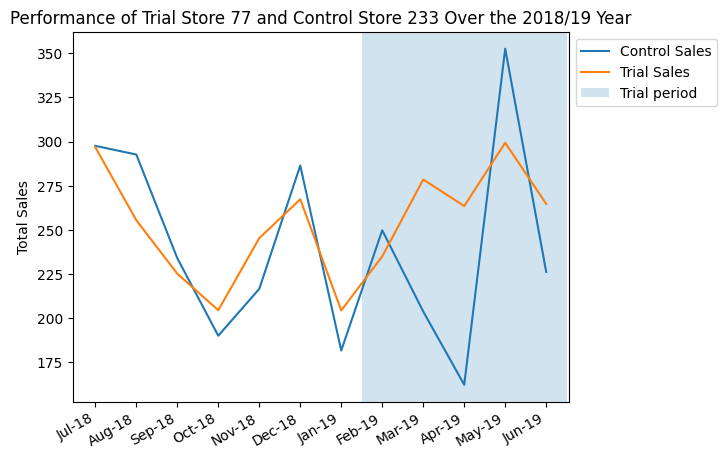

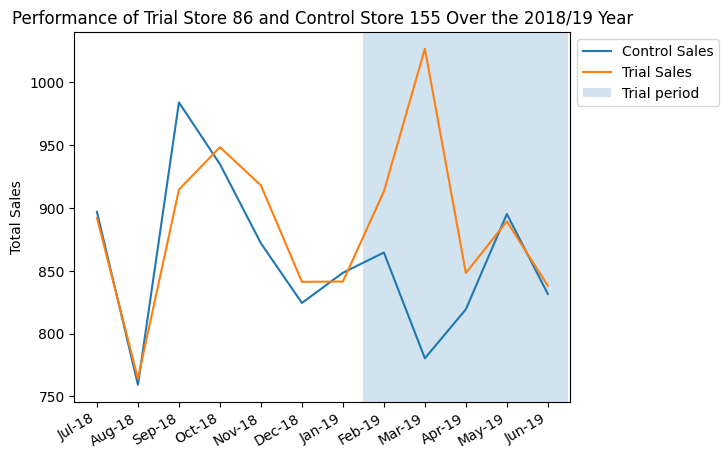

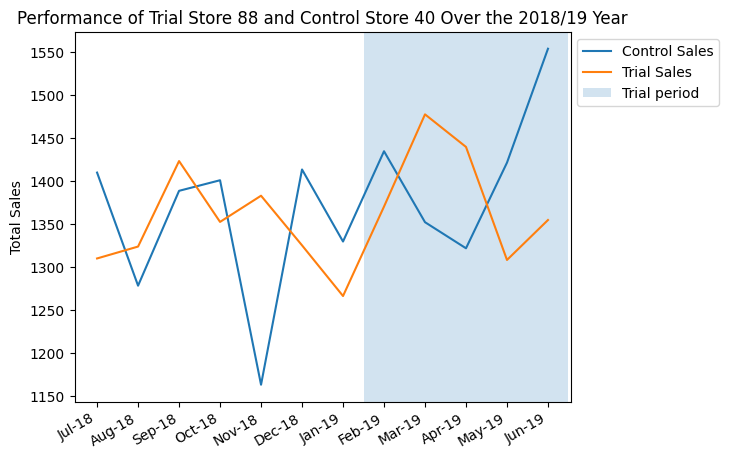

In [58]:
from matplotlib.patches import Rectangle
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]
    
    # Plot the line graph of sales performance 
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control)][['YEARMONTH', 'CONTROL_NBR', 'scaled_sales_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_sales_c": "control_sales"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial)][['YEARMONTH', 'TRIAL_NBR', 'tot_sales_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "tot_sales_t": "trial_sales"})
    
    ax = plot_control.plot.line(x = "YEARMONTH", y = 'control_sales', use_index=False, label = 'Control Sales')
    ax_trial = plot_trial.plot.line(x = "YEARMONTH", y = 'trial_sales', use_index=False, ax=ax, label = 'Trial Sales')
    
    ax.add_patch(Rectangle((6.5, 0), 5, 2000, alpha = 0.2, label = 'Trial period'))
    
    # Other plot features
    ax.set_ylabel('Total Sales')
    plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
    titlestr = f'Performance of Trial Store {trial} and Control Store {control} Over the 2018/19 Year'
    positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
    labels = ("Jul-18", 'Aug-18', 'Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19')
    plt.xticks(positions, labels)
    ax.set_title(titlestr)
    ax.set_xticklabels(labels, rotation=30, ha='right')  # Rotate 30 degrees and align right
    
    plt.show()

We can now do the same for number of customers.

In [59]:
# Calculate the scaling factor for the store pairs
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['n_cust'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['n_cust'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['n_cust'].sum()

# Extract the control store data from the df and scale according to the store 
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control233.n_cust *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control155.n_cust *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control40.n_cust *= scale_store88

# Combine the scaled control stores to a single df
scaledncust_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledncust_control = scaledncust_control.rename(columns = {'n_cust':'scaled_n_cust', 'STORE_NBR': 'CONTROL_NBR'}) 
# Get the trial period of scaled control stores 
scaledncust_control_trial = scaledncust_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201906)].reset_index(drop = True)

# Get the trial period of the trial stores 
trialncust = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'n_cust']].reset_index(drop = True)
trialncust = trialncust.rename(columns = {'STORE_NBR': 'TRIAL_NBR'}) 
trialncust_trial = trialncust[(trialncust.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201906)].reset_index(drop = True)

# Calculate the percentage difference between the control and trial store pairs for each month over the year   
percentdiff = scaledncust_control.copy()
percentdiff[['TRIAL_NBR', 'n_cust_t']] = trialncust[['TRIAL_NBR', 'n_cust']]
percentdiff = percentdiff.rename(columns = {'scaled_n_cust' : 'scaled_n_cust_c'})
percentdiff['cust_percent_diff'] = (percentdiff.n_cust_t-percentdiff.scaled_n_cust_c)\
                                    /(0.5*((percentdiff.scaled_n_cust_c+percentdiff.n_cust_t)))

percentdiff


,CONTROL_NBR,YEARMONTH,scaled_n_cust_c,TRIAL_NBR,n_cust_t,cust_percent_diff
0,233,201807,51.171141,77,51,-0.003350
1,233,201808,48.161074,77,47,-0.024402
2,233,201809,42.140940,77,42,-0.003350
3,233,201810,35.117450,77,37,0.052208
4,233,201811,40.134228,77,41,0.021342
5,233,201812,47.157718,77,46,-0.024855
6,233,201901,35.117450,77,35,-0.003350
7,233,201902,45.151007,77,45,-0.003350
8,233,201903,40.134228,77,50,0.218913
9,233,201904,30.100671,77,47,0.438370


Now the t-test.

In [60]:
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['cust_percent_diff'].agg('std').reset_index()
dof = 6 # 7 months of data - 1 

for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['cust_percent_diff'].agg('std')
    mean =  pretrial['cust_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201906) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['cust_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()
    
# Generate the t-statistic for the 95% percentile with 6 dof
print ('95th percentile value:', t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.19886295797440687
201903  :  8.009609025380932
201904  :  16.114474772873923
201905  :  -1.5177966909503502
201906  :  -0.19886295797440234

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  6.220524882227514
201903  :  10.52599074274189
201904  :  3.0763575852842706
201905  :  -1.0051000829345191
201906  :  1.6226606374395418

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.3592881735131531
201903  :  1.2575196020616801
201904  :  0.6092905590514273
201905  :  -0.9882464088335691
201906  :  -2.2560432736372547

95th percentile value: 1.9431802805153018


We can see from the above results that similar to the total sales metric, there are statistically significant increases in the number of customers in stores 77 and 86 in March and April during the trial period. However, there is no significant increase in store 88.

We can now visualize this.

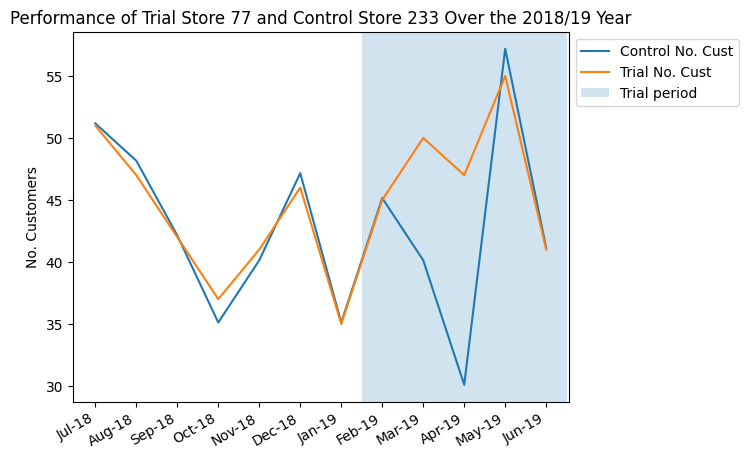

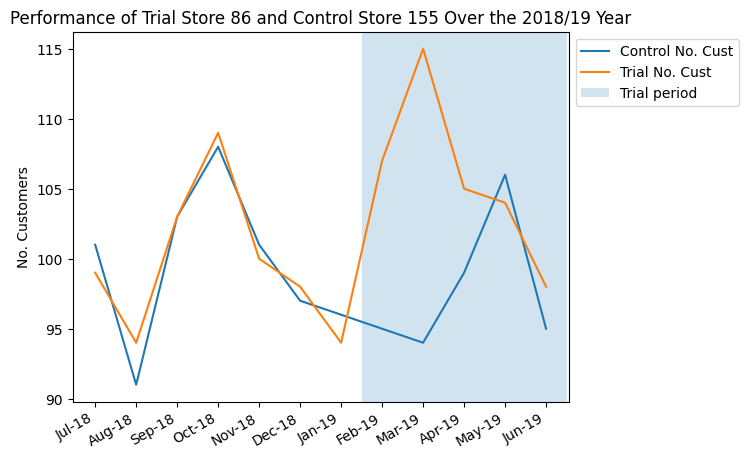

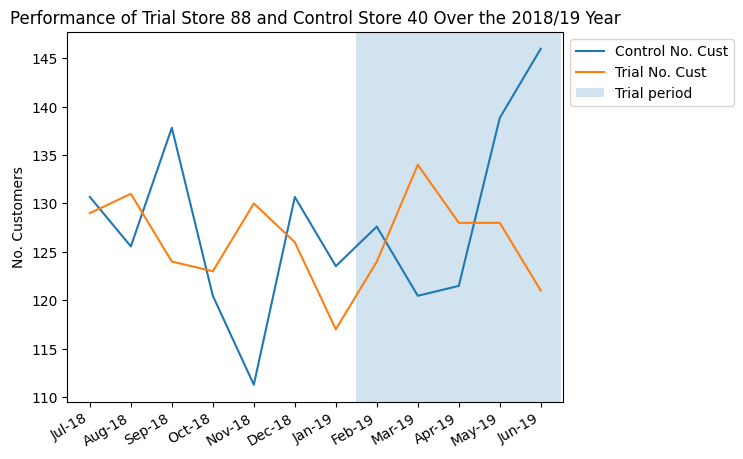

In [61]:
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]    
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_n_cust_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_n_cust_c": "control_ncust"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'n_cust_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "n_cust_t": "trial_ncust"})
    
    ax = plot_control.plot.line(x = "YEARMONTH", y = 'control_ncust', use_index=False, label = 'Control No. Cust')
    ax_trial = plot_trial.plot.line(x = "YEARMONTH", y = 'trial_ncust', use_index=False, ax=ax, label = 'Trial No. Cust')
    
    ax.add_patch(Rectangle((6.5, 0), 5, 2000, alpha = 0.2, label = 'Trial period'))  
    
    # Other plot features
    ax.set_ylabel('No. Customers')
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Performance of Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' Over the 2018/19 Year'
    positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
    labels = ("Jul-18", 'Aug-18', 'Sep-18', 'Oct-18', 'Nov-18', 'Dec-18', 'Jan-19', 'Feb-19', 'Mar-19', 'Apr-19', 'May-19', 'Jun-19')
    plt.xticks(positions, labels)
    ax.set_title(titlestr)
    ax.set_xticklabels(labels, rotation=30, ha='right')  # Rotate 30 degrees and align right

    plt.show()

 The results for trial stores 77 and 88 during the trial period show a significant increase in both number of customers and sales in at least two of the three trial months but not so for store 86.